## Big Smart Sales

The description of the challenge is given in the following [link](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/)

In [2]:
# Loading necesary packages
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor,Pool,cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [219]:
# Loading training and test set
path = 'C:/Users/fmarquezm/Escritorio/Challenges/AnalyticsVidhya/Big Mart Sales'
train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')

In [4]:
# First rows
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# Data Types and Missing Values
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB
None


In [5]:
print('Number of Stores: {}'.format(len(train.Outlet_Identifier.value_counts())))
print('Number of products: {}'.format(len(train.Item_Identifier.value_counts())))

Number of Stores: 10
Number of products: 1559


In [6]:
# There are two marked groups of stores considering the number of products they sell.
train.Outlet_Identifier.value_counts()

OUT027    935
OUT013    932
OUT035    930
OUT046    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text xticklabel objects>)

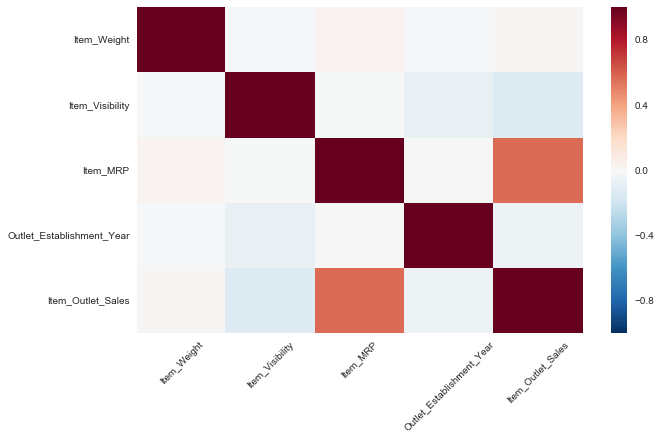

In [7]:
# Correlations
plt.figure(figsize=(10,6))
corr = train.corr()
sns.heatmap(corr)
plt.xticks(rotation = 45)

Item_MRP is the only feature with high correlation with Item_Outlet_Sales

In [8]:
# Item_MRP is the on
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


### Item_Weight

Item_Weight contains a considerable amount of missing values. Let's study them:

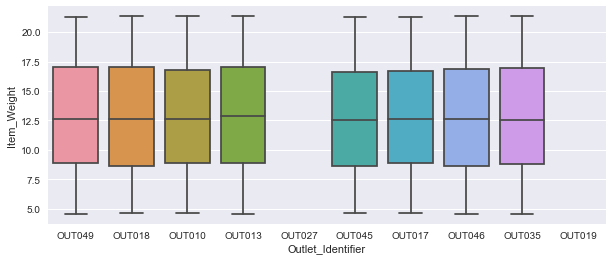

In [14]:
# Item_Weight per Outlet
plt.figure(figsize=(10,4))
sns.boxplot(x='Outlet_Identifier',y='Item_Weight',data=train)

We can note that missing weights of products correspond to Outlets "OUT027" and "OUT019". It means that the weight of some products that were sold in these outlets were not reported. If other outlets sell these products, we can complete using the weights they registered. In this way, we are going to create a data frame containing all products and their corresponding weights.

In [182]:
product_weight = train[['Item_Identifier','Item_Weight']].groupby('Item_Identifier',as_index=False).mean()

However, we can notice that there are four products with missing weights that are not sell in other Outlets. We will impute them.

In [66]:
# Existen aún 4 productos que no han sido clasificado en otras tiendas.
product_weight[product_weight.Item_Weight.isnull()]

,Item_Identifier,Item_Weight
351,FDE52,NaN
577,FDK57,NaN
686,FDN52,NaN
819,FDQ60,NaN


### Item_Fat_Content

Labels such as 'reg' and 'Regular' correspond to the same label 'Regular' and 'LF','low fat' and 'Low Fat' correspond to the dame label 'Low Fat'

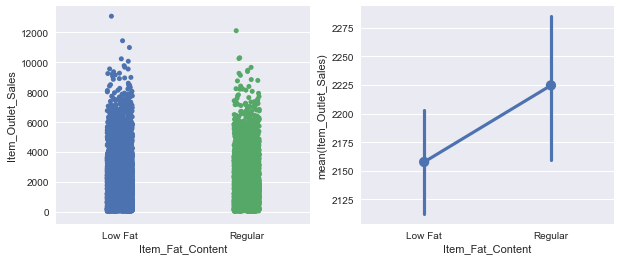

In [10]:
train_p = train[['Item_Fat_Content','Item_Outlet_Sales']]
train_p.Item_Fat_Content = np.where(train_p.Item_Fat_Content.apply(lambda x:x in ['Regular','reg']),'Regular','Low Fat')

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(10,4))
sns.stripplot(x="Item_Fat_Content", y="Item_Outlet_Sales", data=train_p,jitter=True,ax=axs[0])
sns.pointplot(x='Item_Fat_Content',y='Item_Outlet_Sales',data=train_p,ax=axs[1])

However,, tenemos que darnos cuenta que existen tipos de productos, a los cuales no tiene sentido asignarle un contenido de grasas bajo o regular. Por ejemplo, los productos de Higiene y Salud, productos del hogar y Otros. Entonces, crearemos una nueva categoría llamada "None" en la variable contenido en grasas.

### Item_MRP

The max price of products are considerably correlated with the total sales.

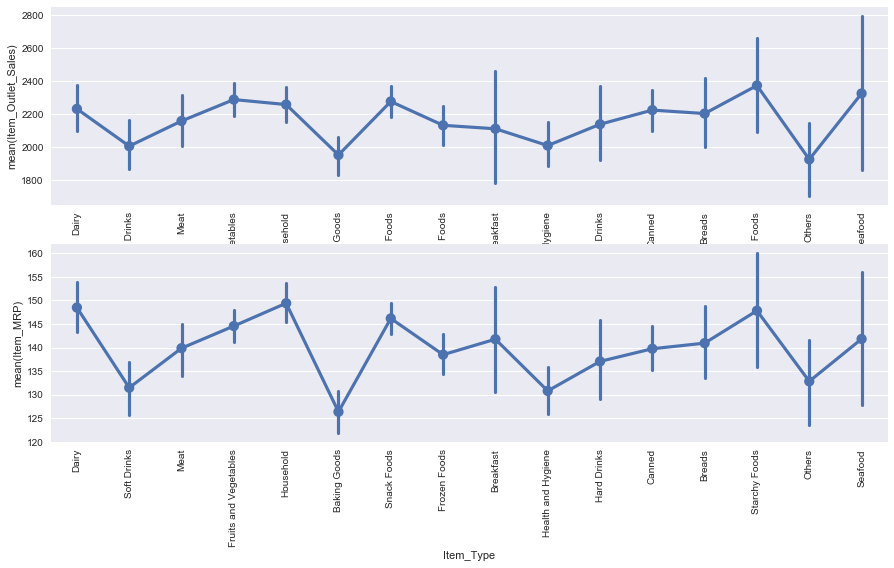

In [11]:
fig, axs = plt.subplots(nrows=2,figsize=(15,8),)
sns.pointplot(x='Item_Type',y='Item_Outlet_Sales',data=train,ax=axs[0])
sns.pointplot(x='Item_Type',y='Item_MRP',data=train,ax=axs[1])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

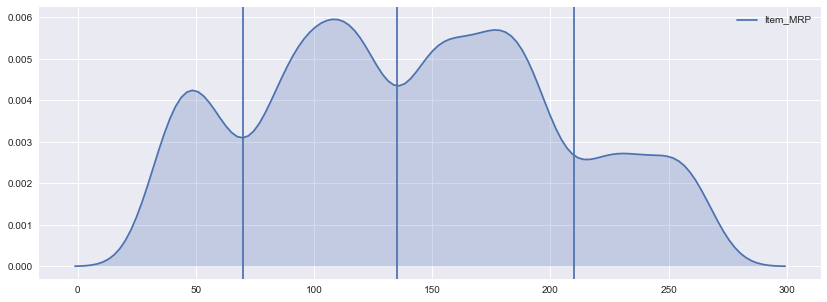

In [31]:
plt.figure(figsize=(14,5))
sns.kdeplot(train.Item_MRP,shade=True)
plt.axvline(x=70)
plt.axvline(x=135)
plt.axvline(x=210)

We can bin this variable to form a new categorical feature with four labels.

### Outlet_Establishment_Year

We are going to transform this feature in how old the outlets are considering that the information of sales is about 2013. Furthermore, we note that total sales of oulets opened in 1998 registered really low compared to the other outlets. We will create a flag feature to indicate this difference.

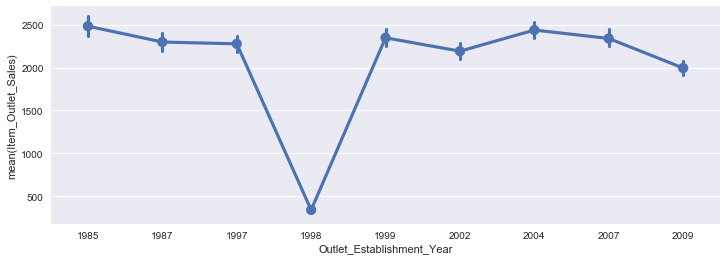

In [12]:
plt.figure(figsize=(12,4))
sns.pointplot(x='Outlet_Establishment_Year',y='Item_Outlet_Sales',data=train)

### Outlet_Size

Some outlets did not registered their size.

In [37]:
train.Outlet_Identifier[pd.isnull(train.Outlet_Size)].value_counts()

OUT045    929
OUT017    926
OUT010    555
Name: Outlet_Identifier, dtype: int64

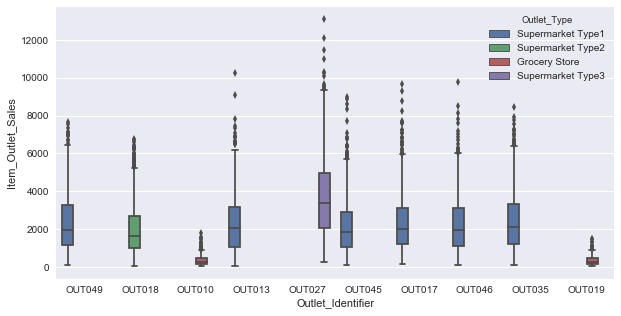

In [44]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Outlet_Identifier',y='Item_Outlet_Sales',hue='Outlet_Type',data=train)

Outlets 10 and 19 register the lowest total sales amount, because they are grocery stores, and they may not offer the same quantity of products as a supermarket may do.

In [40]:
train.Outlet_Type[train.Outlet_Identifier.apply(lambda x:x in ['OUT010','OUT019'])].unique()

array(['Grocery Store'], dtype=object)

We can see that, OUT010 is a 'Grocery store' so its shape would be "Small". On the other hand, OUT017 and OUT045 are supermarkets of Type 1. This type contains outlets of different shapes, small medium and high. It is kinf of difficult to set a size considering the type of outlet.

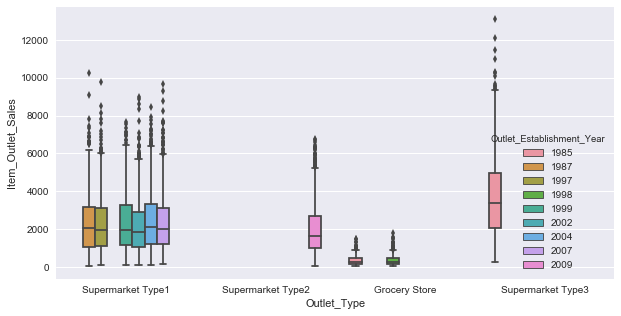

In [50]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Outlet_Type',y='Item_Outlet_Sales',hue='Outlet_Establishment_Year',data=train)

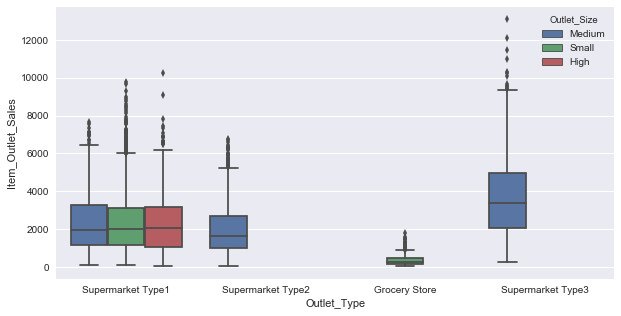

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Outlet_Type',y='Item_Outlet_Sales',hue='Outlet_Size',data=train)

In [52]:
train[['Outlet_Size','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Location_Type']].drop_duplicates()

,Outlet_Size,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type
0,Medium,OUT049,1999,Tier 1
1,Medium,OUT018,2009,Tier 3
3,NaN,OUT010,1998,Tier 3
4,High,OUT013,1987,Tier 3
7,Medium,OUT027,1985,Tier 3
8,NaN,OUT045,2002,Tier 2
9,NaN,OUT017,2007,Tier 2
11,Small,OUT046,1997,Tier 1
19,Small,OUT035,2004,Tier 2
23,Small,OUT019,1985,Tier 1


Outlets 10 and 45, will be labeled as "Small" for two reasons. First, they are located in Olcation_Type Tier2, which seems to contain small outlets and second beacuse inside Supermarket 1 type ,"Small" is the most common size category. In conclusion, all missing sizes will be labeled as Small.

In [14]:
# Composition of Total Sales per Store and
# store_total = train[['Outlet_Identifier','Item_Outlet_Sales']].groupby('Outlet_Identifier',as_index=False).sum()
# store_total.Item_Outlet_Sales = store_total.Item_Outlet_Sales/sum(store_total.Item_Outlet_Sales)
# store_total.rename(columns={'Item_Outlet_Sales':'Comp_sales_store'},inplace=True)
# item_total = train[['Item_Identifier','Item_Outlet_Sales']].groupby('Item_Identifier',as_index=False).sum()
# item_total.Item_Outlet_Sales = item_total.Item_Outlet_Sales/sum(item_total.Item_Outlet_Sales)
# item_total.rename(columns={'Item_Outlet_Sales':'Comp_sales_item'},inplace=True)

In [271]:
# print(store_total.head())
# print(item_total.head())

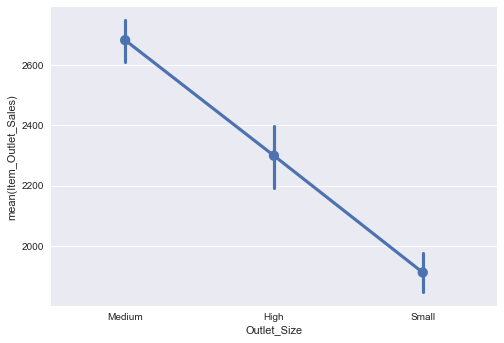

In [16]:
# Outlet_Size
train.Outlet_Size.value_counts()
sns.pointplot(x='Outlet_Size',y='Item_Outlet_Sales',data=train)

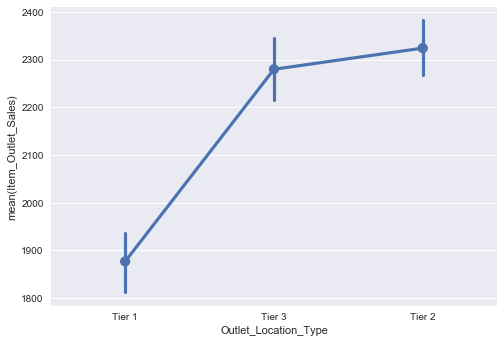

In [17]:
# Outlet_Location_Type
train.Outlet_Location_Type.value_counts()
sns.pointplot(x='Outlet_Location_Type',y='Item_Outlet_Sales',data=train)

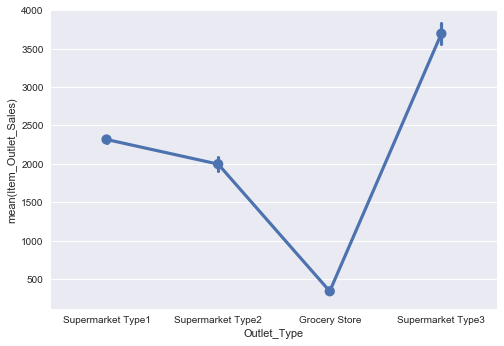

In [18]:
# Outlet_Type
train.Outlet_Type.value_counts()
sns.pointplot(x='Outlet_Type',y='Item_Outlet_Sales',data=train)

### Feature Engineering

In [220]:
# Item_Fat_Content: Regular = 1, Low_Fat = 0
train.Item_Fat_Content = np.where(train.Item_Fat_Content.apply(lambda x:x in ['Regular','reg']),'Regular','Low Fat')
condt = train.Item_Type.apply(lambda x:x in ['Household','Health and Hygiene','Others']) 
train.Item_Fat_Content[condt] = 'None'

In [221]:
# Outlet_Establishment_Year -> Old 
train['Old'] = 2013 - train.Outlet_Establishment_Year
train['Flag_1998'] = np.where(train.Outlet_Establishment_Year == 1998,1,0)

In [222]:
# Item_Weight
new_dt = train.loc[train.Item_Weight.isnull(),['Item_Identifier','Item_Weight']].set_index('Item_Identifier',)
new_dt.update(product_weight.set_index('Item_Identifier'))
train.Item_Weight[train.Item_Weight.isnull()] = new_dt.values
train.Item_Weight.fillna(train.Item_Weight.mean(),inplace=True)

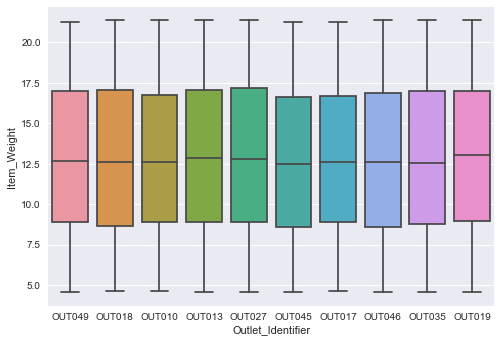

In [223]:
sns.boxplot(x='Outlet_Identifier',y='Item_Weight',data=train)

In [224]:
# Outlet_Size
train.Outlet_Size.fillna('Small',inplace=True)

In [106]:
# Item_MRP
#train['Item_MRP_cat'] = pd.cut(x=train.Item_MRP,bins=[0,70,135,210,1000],
#                        labels=['<=70','<70-135]','<135-210]','>210'])

In [225]:
# New class of products
train['New_class'] = train['Item_Identifier'].str[0:2]

In [189]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Old,Flag_1998,New_class
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14,0,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4,0,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14,0,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,15,1,FD
4,NCD19,8.93,None,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26,0,NC


In [ ]:
# Impute train y test set
#train.fillna(-999,inplace=True)
#test.fillna(-999,inplace=True)

In [226]:
# Train/Test Split
X = train.drop(['Item_Outlet_Sales','Item_Identifier',
               'Outlet_Establishment_Year'],axis=1)
y = train.Item_Outlet_Sales

X_train,X_validation,y_train,y_validation = train_test_split(X,y,train_size = 0.8,random_state=1234)

In [227]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Old,Flag_1998,New_class
6774,15.100,None,0.097769,Household,142.4496,OUT019,Small,Tier 1,Grocery Store,28,0,NC
1224,6.590,None,0.043828,Household,121.4098,OUT010,Small,Tier 3,Grocery Store,15,1,NC
2308,8.185,Low Fat,0.046556,Fruits and Vegetables,47.7692,OUT049,Medium,Tier 1,Supermarket Type1,14,0,FD
2136,13.650,Low Fat,0.040050,Frozen Foods,34.4558,OUT017,Small,Tier 2,Supermarket Type1,6,0,FD
4375,7.565,None,0.054376,Health and Hygiene,56.2930,OUT027,Medium,Tier 3,Supermarket Type3,28,0,NC


In [228]:
# Identificar variables categóricas
categorical_features_indices = [1,3,5,6,7,8,11]

### Modeling

We will train a CatBoost Regressor for this situation.

In [238]:
model = CatBoostRegressor(iterations=200,depth=5,learning_rate=0.1,loss_function='RMSE',
                          random_seed=1234,use_best_model=True,temperature=0.5)
model.fit(X_train,y_train,cat_features = categorical_features_indices,eval_set=(X_validation,y_validation),plot=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


We can see that training and validation error are consistent.

### Feature Importance

In [261]:
df = pd.DataFrame([])
df['feature'] = X_train.columns.values
df['importance'] = model.feature_importance_
df.sort_values('importance',ascending=False,inplace=True)

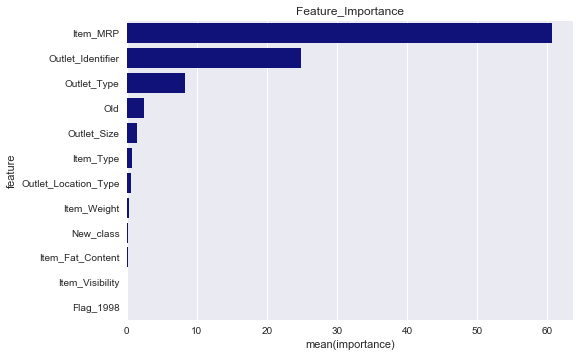

In [270]:
sns.barplot(y='feature',x='importance',data=df,orient='h',color='darkblue')
plt.title('Feature_Importance')

### Evaluation Metric via Cross Validation

In [195]:
cv_data = cv(
    model.get_params(),
    Pool(X_train, label=y_train, cat_features=categorical_features_indices),
    fold_count=10
)

In [196]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.min(cv_data["b'RMSE'_test_avg"]),
    cv_data["b'RMSE'_test_stddev"][np.argmin(cv_data["b'RMSE'_test_avg"])],
    np.argmin(cv_data["b'RMSE'_test_avg"])
))

Best validation accuracy score: 1070.29±39.10 on step 61


In [197]:
# Evaluatibg Test Set
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_validation)
print('MSE = {}'.format(np.sqrt(mean_squared_error(y_validation,predictions))))
print('STD_errors = {}'.format(np.std(y_validation-predictions)))

MSE = 1106.6769695602875
STD_errors = 1106.1786444170868


In [232]:
# Transformations_Test_Set
test.Item_Fat_Content = np.where(test.Item_Fat_Content.apply(lambda x:x in ['Regular','reg']),'Regular','Low Fat')
condt = test.Item_Type.apply(lambda x:x in ['Household','Health and Hygiene','Others']) 
test.Item_Fat_Content[condt] = 'None'
test['Old'] = 2013 - test.Outlet_Establishment_Year
test['Flag_1998'] = np.where(test.Outlet_Establishment_Year == 1998,1,0)
new_dt = test.loc[test.Item_Weight.isnull(),['Item_Identifier','Item_Weight']].set_index('Item_Identifier',)
new_dt.update(product_weight.set_index('Item_Identifier'))
test.Item_Weight[test.Item_Weight.isnull()] = new_dt.values
test.Item_Weight.fillna(train.Item_Weight.mean(),inplace=True)
test.Outlet_Size.fillna('Small',inplace=True)
test['New_class'] = test['Item_Identifier'].str[0:2]

In [179]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Old,Flag_1998,new_var,New_class
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,14,0,-8.349470,FD
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,6,0,4.100532,FD
2,NCN55,14.600,None,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,15,1,-2.199532,NC
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,6,0,5.085531,FD
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,28,0,-1.199465,FD


In [239]:
# Submission
submission = pd.DataFrame()
submission['Item_Identifier'] = test['Item_Identifier']
submission['Outlet_Identifier'] = test['Outlet_Identifier']
submission['Item_Outlet_Sales'] = model.predict(test.drop(['Outlet_Establishment_Year','Item_Identifier',
                                                          ],axis=1))
submission.to_csv(path + "/Submission.csv")